In [1]:
# !pip install numpy-financial
import pandas as pd
import numpy as np
import re
import numpy_financial as npf
import matplotlib.pyplot as plt
import joblib

In [2]:
## 최종 데이터 불러오기 (예측하고자 하는 csv 파일 불러오기) *** 이 부분 수정 ***
test_df = pd.read_csv('./data/lending_club_2020_test.csv') 

## 데이터 전처리

In [ ]:
# loan_status 정제: 0=정상상환, 1=부도
test_df = test_df[test_df['loan_status'].isin(
    ['Fully Paid', 
     'Charged Off',
     'Does not meet the credit policy. Status:Fully Paid',
     'Does not meet the credit policy. Status:Charged Off',
     'Default']
)]

label_map = {
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 1
}

test_df['loan_status'] = test_df['loan_status'].map(label_map)

# 공동 신청 제거 및 관련 변수 제거
test_df = test_df[test_df['application_type'] == 'Individual']

# 공동 신청자 관련 컬럼 제거
sec_app_cols = [col for col in test_df.columns if 'sec' in col]
test_df = test_df[test_df.columns.difference(sec_app_cols)]

joint_cols = [col for col in test_df.columns if 'joint' in col]
test_df = test_df[test_df.columns.difference(joint_cols)]

# application_type == 'Joint App' 제거
test_df = test_df[test_df['application_type'] == 'Individual']
sec_app_cols = [col for col in test_df.columns if 'sec' in col]
test_df = test_df[test_df.columns.difference(sec_app_cols)]
joint_cols = [col for col in test_df.columns if 'joint' in col]
test_df = test_df[test_df.columns.difference(joint_cols)]

# hardship col 제거
hardship_cols = [col for col in test_df.columns if 'hardship' in col]
test_df = test_df[test_df.columns.difference(hardship_cols)]

# settle col 제거
settle_cols = [col for col in test_df.columns if 'settle' in col]
test_df = test_df[test_df.columns.difference(settle_cols)]

# 상관계수 높은 컬럼 쌍 중 하나 제거
remove_col = ['orig_projected_additional_accrued_interest', 
              'initial_list_status',
              'last_fico_range_high', 
              'last_fico_range_low', 'last_pymnt_amnt',
              'last_pymnt_d', 'next_pymnt_d',
              'out_prncp', 'out_prncp_inv', 'policy_code', 'pymnt_plan',
              'url', 'recoveries', 'delinq_amnt', 'total_pymnt_inv',
              'funded_amnt_inv', 'total_rec_prncp',
              'num_sats', # open_acc 와 상관관계 0.9 이상
              'num_rev_tl_bal_gt_0', # num_actv_rev_tl 상관관계 0.9 이상
              'total_bal_il',  # total_bal_ex_mort
              'avg_cur_bal', # tot_cur_bal
              'tot_cur_bal', 
              'total_il_high_credit_limit', #total_bal_ex_mort
              'percent_bc_gt_75', # bc_util
              'open_rv_24m', # acc_open_past_24mths
              'open_rv_12m', # num_tl_op_past_12m
              'zip_code',
              'application_type', 'title',
              'emp_title', 'collection_recovery_fee',
              'deferral_term', 'payment_plan_start_date',
               'total_rec_int', 'total_rec_late_fee',
]

test_df = test_df[test_df.columns.difference(remove_col)]

# 결측치가 40% 이상인 컬럼 제거
remove_col = ['all_util', 'il_util', 'inq_fi', 'inq_last_12m', 
              'max_bal_bc', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_cu_tl']
test_df = test_df[test_df.columns.difference(remove_col)]

test_df['mort_acc'] = test_df['mort_acc'].fillna(0)
test_df['mort_acc'] = test_df['mort_acc'].clip(upper=6)
test_df['acc_now_delinq'] = test_df['acc_now_delinq'].fillna(0)
test_df['acc_open_past_24mths'] = test_df['acc_open_past_24mths'].fillna(0)
test_df['acc_open_past_24mths'] = test_df['acc_open_past_24mths'].clip(upper=10)
test_df = test_df[test_df['annual_inc'].notna()]
test_df['annual_inc'] = np.log1p(test_df['annual_inc'])  
test_df['open_acc'] = test_df['open_acc'].fillna(0)
test_df['open_acc'] = np.log1p(1 + test_df['open_acc'])  
test_df['tax_liens'] = test_df['tax_liens'].fillna(0)
test_df['tax_liens'] = (test_df['tax_liens'] > 0).astype(int)
test_df['revol_bal'] = np.log1p(1 + test_df['revol_bal'])  
test_df['pub_rec_bankruptcies'] = test_df['pub_rec_bankruptcies'].fillna(0)
test_df['pub_rec_bankruptcies'] = (test_df['pub_rec_bankruptcies'] > 0).astype(int)
test_df['collections_12_mths_ex_med'] = test_df['collections_12_mths_ex_med'].fillna(0)
test_df['collections_12_mths_ex_med'] = (test_df['collections_12_mths_ex_med'] > 0).astype(int)
test_df['delinq_2yrs'] = (test_df['delinq_2yrs'] > 0).astype(int)
test_df['pub_rec'] = (test_df['pub_rec'] > 0).astype(int)
test_df['revol_util'] = test_df['revol_util'].str.rstrip('%').astype(float)
test_df = test_df[test_df['revol_util'] < 350]
test_df['revol_util'] = np.log1p(1 + test_df['revol_util'])  
test_df['inq_last_6mths'] = pd.cut(
    test_df['inq_last_6mths'],
    bins=[-1,0,1,100],
    labels=[0, 1, 2]
)
test_df['term'] = test_df['term'].str.replace(' months', '').str.strip().astype(int)
test_df['term'] = (test_df['term'] == 36).astype(int)
test_df['emp_length'] = test_df['emp_length'].fillna('unknown')
test_df['home_ownership'] = test_df['home_ownership'].replace({'ANY': 'OTHER', 'NONE': 'OTHER', 'OTHER': 'OTHER'})

def delinq_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    else:
        return '5yr+'

test_df['mths_since_last_delinq'] = test_df['mths_since_last_delinq'].apply(delinq_cat)

def major_derog_cat_simple(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 72:
        return '5-6yr'
    else:
        return '6yr+'

test_df['mths_since_last_major_derog'] = test_df['mths_since_last_major_derog'].apply(major_derog_cat_simple)

mask = test_df['mths_since_last_record'].notna()
test_df.loc[mask, 'mths_since_last_record'] = test_df.loc[mask, 'mths_since_last_record'].astype(int)

def record_bin_1to9plus(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 36:
        return '<3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 72:
        return '5-6yr'
    elif x <= 84:
        return '6-7yr'
    elif x <= 96:
        return '7-8yr'
    else:
        return '9yr+'

test_df['mths_since_last_record'] = test_df['mths_since_last_record'].apply(record_bin_1to9plus)

def rcnt_il_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x<= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    else:
        return '2yr+'

test_df['mths_since_rcnt_il'] = test_df['mths_since_rcnt_il'].apply(rcnt_il_cat)

def recent_bc_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    else:
        return '3yr+'

test_df['mths_since_recent_bc'] = test_df['mths_since_recent_bc'].apply(recent_bc_cat)

def recent_bc_dlq_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    else:
        return '5yr+'

test_df['mths_since_recent_bc_dlq'] = test_df['mths_since_recent_bc_dlq'].apply(recent_bc_dlq_cat)

def inq_bin(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 0:
        return '0'
    elif x == 1:
        return '1'
    elif x == 2:
        return '2'
    elif x == 3:
        return '3'
    elif x == 4:
        return '4'
    elif x == 5:
        return '5'
    elif x == 6:
        return '6'
    elif x == 7:
        return '7'
    elif x == 8:
        return '8'
    elif x == 9:
        return '9'
    else:
        return '10+'

test_df['mths_since_recent_inq'] = test_df['mths_since_recent_inq'].apply(inq_bin)

def revol_delinq_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    else:
        return '5yr+'

test_df['mths_since_recent_revol_delinq'] = test_df['mths_since_recent_revol_delinq'].apply(revol_delinq_cat)

test_df['fico'] = (test_df['fico_range_high'] + test_df['fico_range_low']) / 2
test_df = test_df.drop(['fico_range_high', 'fico_range_low'], axis=1)

test_df['earliest_cr_line'] = pd.to_datetime(test_df['earliest_cr_line'], format='%b-%Y')
test_df['issue_d'] = pd.to_datetime(test_df['issue_d'], format='%b-%Y')

test_df['credit_hist_months'] = (
    test_df['issue_d'].dt.to_period('M')
  - test_df['earliest_cr_line'].dt.to_period('M')
).apply(lambda x: x.n)

test_df = test_df.drop('earliest_cr_line', axis=1)
test_df['tot_coll_amt'] = test_df['tot_coll_amt'].fillna(0)
test_df['tot_coll_amt'] = np.log1p(1 + test_df['tot_coll_amt'])  
test_df['num_accts_ever_120_pd'] = test_df['num_accts_ever_120_pd'].fillna(0)
test_df['mo_sin_old_il_acct'] = test_df['mo_sin_old_il_acct'].fillna(0)
test_df['chargeoff_within_12_mths'] = test_df['chargeoff_within_12_mths'].fillna(0)
test_df['chargeoff_within_12_mths'] = (test_df['chargeoff_within_12_mths'] >= 1).astype(int)

# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = test_df['total_bal_ex_mort'].median()
test_df['total_bal_ex_mort'] = test_df['total_bal_ex_mort'].fillna(median_val)

test_df['total_bal_ex_mort'] = np.log1p(1 + test_df['total_bal_ex_mort'])  

# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = test_df['pct_tl_nvr_dlq'].median()
test_df['pct_tl_nvr_dlq'] = test_df['pct_tl_nvr_dlq'].fillna(median_val)
test_df = test_df.drop('last_credit_pull_d', axis=1) # 사후 변수

# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = test_df['mo_sin_old_rev_tl_op'].median()
test_df['mo_sin_old_rev_tl_op'] = test_df['mo_sin_old_rev_tl_op'].fillna(median_val)
test_df['mo_sin_old_rev_tl_op'] = np.log1p(1 + test_df['mo_sin_old_rev_tl_op'])  

# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = test_df['tot_hi_cred_lim'].median()
test_df['tot_hi_cred_lim'] = test_df['tot_hi_cred_lim'].fillna(median_val)
test_df['tot_hi_cred_lim'] = np.log1p(1 + test_df['tot_hi_cred_lim']) 

test_df['bc_util'] = (test_df['total_bc_limit'] - test_df['bc_open_to_buy']) / test_df['total_bc_limit'] * 100
test_df = test_df.drop('total_bc_limit', axis=1) # 사후 변수

test_df['have_bc'] = (~(test_df['bc_open_to_buy'].isna())).astype(int)

mean_val = test_df['bc_util'].mean()
test_df['bc_util'] = test_df['bc_util'].fillna(mean_val)

median_val = test_df['bc_open_to_buy'].median()
test_df['bc_open_to_buy'] = test_df['bc_open_to_buy'].fillna(median_val)
test_df['bc_open_to_buy'] = np.log1p(1 + test_df['bc_open_to_buy'])  

median_val = test_df['num_tl_op_past_12m'].median()
test_df['num_tl_op_past_12m'] = test_df['num_tl_op_past_12m'].fillna(median_val)

test_df['num_tl_90g_dpd_24m'] = test_df['num_tl_90g_dpd_24m'].fillna(0)
test_df['num_tl_90g_dpd_24m'] = (test_df['num_tl_90g_dpd_24m'] > 0).astype(int)

test_df['num_rev_accts'] = test_df['num_rev_accts'].fillna(0)
test_df['num_op_rev_tl'] = test_df['num_op_rev_tl'].fillna(0)

test_df['num_rev_accts'] = np.log1p(1 + test_df['num_rev_accts'])  
test_df['num_op_rev_tl'] = np.log1p(1 + test_df['num_op_rev_tl'])
test_df['total_acc'] = np.log1p(1 + test_df['total_acc'])

# 1) “mo_sin_rcnt_rev_tl_op”과 “mo_sin_rcnt_tl” 모두 NaN인 행 마스크
mask_no_rev = test_df['mo_sin_rcnt_rev_tl_op'].isna() & test_df['mo_sin_rcnt_tl'].isna()
# 2) have_rev 컬럼 생성: 리볼빙 계좌 정보 없으면 0, 아니면 1
test_df['have_rev'] = (~mask_no_rev).astype(int)

# 3) 중앙값 계산 (리볼빙 계좌가 있는 경우만)
medians = {
    col: test_df.loc[~mask_no_rev, col].median()
    for col in ['mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']
}
# 4) NaN인 행(=mask_no_rev)에 중앙값으로 대체
for col, med in medians.items():
    test_df.loc[mask_no_rev, col] = med
    
test_df['mo_sin_rcnt_rev_tl_op'] = np.log1p(1 + test_df['mo_sin_rcnt_rev_tl_op']) 
test_df['mo_sin_rcnt_tl'] = np.log1p(1 + test_df['mo_sin_rcnt_tl'])  

test_df['num_actv_rev_tl'] = test_df['num_actv_rev_tl'].fillna(0) 

# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = test_df['num_actv_rev_tl'].quantile(0.99)
# 2) 그 값으로 상한(capping) 적용
test_df['num_actv_rev_tl'] = test_df['num_actv_rev_tl'].clip(upper=q99)

test_df['num_bc_tl'] = test_df['num_bc_tl'].fillna(0)
# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = test_df['num_bc_tl'].quantile(0.99)
# 2) 그 값으로 상한(capping) 적용
test_df['num_bc_tl'] = test_df['num_bc_tl'].clip(upper=q99)

test_df['num_il_tl'] = test_df['num_il_tl'].fillna(0)
# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = test_df['num_il_tl'].quantile(0.99)
# 2) 그 값으로 상한(capping) 적용
test_df['num_il_tl'] = test_df['num_il_tl'].clip(upper=q99)

# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = test_df['num_bc_sats'].median()
# 결측값(NaN)을 중앙값으로 대체
test_df['num_bc_sats'] = test_df['num_bc_sats'].fillna(median_val)

# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = test_df['num_bc_sats'].quantile(0.99)
# 2) 그 값으로 상한(capping) 적용
test_df['num_bc_sats'] = test_df['num_bc_sats'].clip(upper=q99)

# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = test_df['num_actv_bc_tl'].median()
# 결측값(NaN)을 중앙값으로 대체
test_df['num_actv_bc_tl'] = test_df['num_actv_bc_tl'].fillna(median_val)

# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = test_df['num_actv_bc_tl'].quantile(0.99)
# 2) 그 값으로 상한(capping) 적용
test_df['num_actv_bc_tl'] = test_df['num_actv_bc_tl'].clip(upper=q99)

test_df['num_tl_120dpd_2m'] = test_df['num_tl_120dpd_2m'].fillna(0)
test_df['num_tl_120dpd_2m'] = (test_df['num_tl_120dpd_2m'] > 0).astype(int)

test_df['num_tl_30dpd'] = test_df['num_tl_30dpd'].fillna(0)
test_df['num_tl_30dpd'] = (test_df['num_tl_30dpd'] > 0).astype(int)

# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = test_df['total_rev_hi_lim'].median()
# 결측값(NaN)을 중앙값으로 대체
test_df['total_rev_hi_lim'] = test_df['total_rev_hi_lim'].fillna(median_val)
test_df['total_rev_hi_lim'] = np.log1p(1 + test_df['total_rev_hi_lim']) 

treasury_3yr = pd.read_csv('./data/treasury_3yr.csv')
treasury_5yr = pd.read_csv('./data/treasury_5yr.csv')

for df_tr in (treasury_3yr, treasury_5yr):
    df_tr['year_month'] = pd.to_datetime(df_tr['year_month'], format='%Y-%m').dt.to_period('M')
    
test_df['year_month']  = test_df['issue_d'].dt.to_period('M')

test_df = (
    test_df
    .merge(treasury_3yr, on='year_month', how='left')
    .merge(treasury_5yr, on='year_month', how='left')
)

test_df['treasury'] = np.where(
    test_df['term'] == 1, test_df['treasury_rate_3yr'],
    np.where(test_df['term'] == 0, test_df['treasury_rate_5yr'], np.nan)
)

# 6) 불필요 컬럼(drop) 및 확인
test_df = test_df.drop(columns=['treasury_rate_3yr', 'treasury_rate_5yr', 'year_month'])
test_df['int_rate'] = test_df['int_rate'].str.rstrip("%").astype(float)
test_df['int_rate'] = (1 + test_df['int_rate']/100) ** (1/12) - 1

# 기존 국채 연 이자율(%) => 월 이자율 단위로 변환(소수)
# 찾아보니 sharpe ratio 계산 시 수익률(이자율)은 %가 아닌 소수로 넣는 게 일반적이라고 합니다!
test_df['treasury'] = ((1 + test_df['treasury']/100) ** (1/12) - 1)

# IRR 계산
test_df['funded_amnt'] = test_df['funded_amnt'].fillna(test_df['loan_amnt'])

def calc_row_irr_full(row):
    # 36개월 fully paid
    if (row['loan_status'] == 0) and (row['term'] == 1):
        n_months = 36
        funded_amnt = row['funded_amnt']
        installment = row['installment']
        cash_flow = [-funded_amnt] + [installment] * n_months
    # 60개월 fully paid
    elif (row['loan_status'] == 0) and (row['term'] == 0):
        n_months = 60
        funded_amnt = row['funded_amnt']
        installment = row['installment']
        cash_flow = [-funded_amnt] + [installment] * n_months
    # 36개월 default or charge off
    elif (row['loan_status'] == 1) and (row['term'] == 1):
        n_months = 36
        funded_amnt = row['funded_amnt']
        total_pymnt = row['total_pymnt']
        mnth_treasury_rate = row['treasury']
        discount_factors = [(1 + mnth_treasury_rate) ** t for t in range(1, n_months + 1)]
        # 매월 유입될 C 계산
        C = total_pymnt / sum(discount_factors)
        cash_flow = [-funded_amnt] + [C] * n_months
    # 60개월 default or charge off
    elif (row['loan_status'] == 1) and (row['term'] == 0):
        n_months = 60
        funded_amnt = row['funded_amnt']
        total_pymnt = row['total_pymnt']
        mnth_treasury_rate = row['treasury']
        discount_factors = [(1 + mnth_treasury_rate) ** t for t in range(1, n_months + 1)]
        # 매월 유입될 C 계산
        C = total_pymnt / sum(discount_factors)
        cash_flow = [-funded_amnt] + [C] * n_months
    else:
        return np.nan

    try:
        irr = npf.irr(cash_flow)
    except:
        irr = np.nan
    return irr

# 일괄 적용 (전체 DataFrame, 모든 경우 대응)
test_df['irr'] = [calc_row_irr_full(row) for row in test_df.to_dict('records')]
# irr의 결측치는 최소값으로 대체: 
# default or charge off에서 irr = NaN 경우는 total_pymnt가 너무 작아 수학적으로 irr이 구해지지 않는 경우
test_df['irr'] = test_df['irr'].fillna(test_df['irr'].min(skipna=True))

with open('./data/selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

with open('./data/categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']
    
test_df_sel = test_df[selected_cols_v1]
test_df_cat = test_df[cat_columns_v1]
test_df_cat = pd.get_dummies(test_df_cat, columns = cat_columns_v1, drop_first=True)
test_df_cat = test_df_cat.astype(int)

test_df_model = pd.concat([test_df_sel, test_df_cat], axis=1)

In [ ]:
# 모델에 넣는 변수들 이외 필요한 변수들 확인
df_else = test_df.drop(selected_cols_v1, axis=1)
df_else = df_else.drop(cat_columns_v1, axis=1)

meta_test = df_else[['loan_status', 'funded_amnt', 'treasury', 'irr']] # 스케일링 되지 않은 값이 필요

df_else.head()

,funded_amnt,id,installment,int_rate,issue_d,loan_amnt,loan_status,sub_grade,total_pymnt,treasury,irr
0,20000.0,3697367,608.72,0.004891,2013-03-01,20000.0,0,A1,21913.551924,0.000321,0.005026
1,12000.0,13046178,283.22,0.011451,2014-03-01,12000.0,1,C3,6001.910000,0.001356,-0.021544
2,15000.0,69533136,451.73,0.004329,2016-02-01,15000.0,0,A1,16141.454015,0.000744,0.004434
3,20000.0,6134635,674.37,0.010274,2013-08-01,20000.0,0,B5,21944.810381,0.000585,0.010876
4,11150.0,46705240,381.03,0.010971,2015-04-01,11150.0,0,C4,13436.829005,0.000718,0.011659


In [ ]:
# 1. 컬럼명 클린업 함수 정의
def clean_feature_names(df):
    df.columns = (
        df.columns
        .astype(str)
        .str.replace('[', '(', regex=False)
        .str.replace(']', ')', regex=False)
        .str.replace('<', 'lt', regex=False)
        .str.replace('>', 'gt', regex=False)
    )
    return df

In [ ]:
X_test = clean_feature_names(test_df_model)
y_test = df_else['irr']

## 모델 불러오기

- xgb_final_loaded.load_model 에 이미 학습된 모델 불러오기    
  
  xgb_final_loaded.load_model(   )  
  


- 예측값에 min max scaling 해야돼서 기존 threshold를 정할 때 적용했던 min max scaler 를 다시 불러와서 사용  
  
  scaler_loaded = joblib.load(   )


In [ ]:
## 모델 불러오기
from xgboost import XGBRegressor
xgb_final_loaded = XGBRegressor()
xgb_final_loaded.load_model("xgb_final_regressor_model.json")

In [ ]:
# 불러오기
scaler_loaded = joblib.load("irr_scaler.pkl")

## 모델의 목적함수는 'irr' 예측하기
y_test_pred = xgb_final_loaded.predict(X_test)

# 학습 때와 동일한 min/max 로 transform만 수행
y_test_pred_scaled = scaler_loaded.transform(y_test_pred.reshape(-1, 1))

# 좌우반전
y_test_pred_scaled = 1 - y_test_pred_scaled

In [ ]:
## 기존 학습된 모델의 optimal threshold
optimal_threshold_final = 0.200100
threshold_IRR_value_test = -0.004938

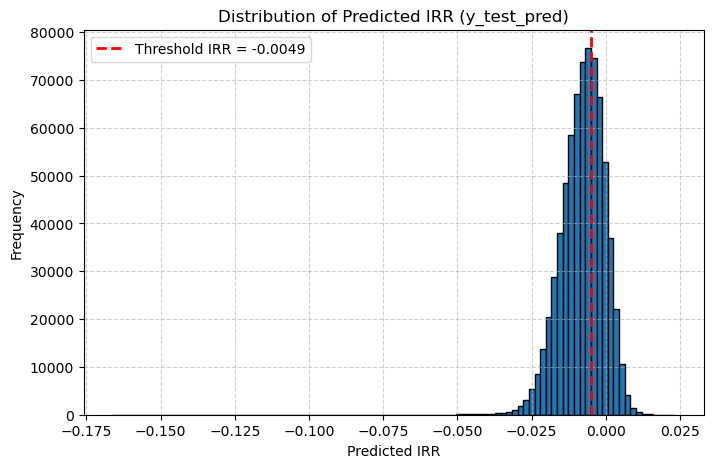

In [ ]:
# 4. MinMaxScaler로 역변환 (좌우반전 포함해서 복원)
#  (1 - threshold) 값을 inverse_transform으로 돌려야 원래 IRR 값으로 복원됨
threshold_IRR_value_test = scaler_loaded.inverse_transform([[1 - optimal_threshold_final]])[0, 0]
# MinMaxScaler로 threshold를 구할 때의 의미 => 빌려줄 때 예측 irr 값의 하한
# (threshold에 해당하는 예측 irr 값이 고정됨)

# 5. 그래프 표시
plt.figure(figsize=(8, 5))
plt.hist(y_test_pred, bins=100, edgecolor='black')
plt.axvline(threshold_IRR_value_test, color='red', linestyle='--', linewidth=2,
            label=f"Threshold IRR = {threshold_IRR_value_test:.4f}")
plt.title("Distribution of Predicted IRR (y_test_pred)")
plt.xlabel("Predicted IRR")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## 최종 모델 검증 - 기존 데이터를 활용한 샤프지수 및 부트스트랩 결과

In [ ]:
import numpy as np

# threshold 기준으로 대출 여부 결정 (0=대출, 1=거절)
test_binary = (y_test_pred_scaled > optimal_threshold_final).astype(int)

# 수익률 계산
val_return = []
for pred, actual, irr, treasury in zip(test_binary, y_test, meta_test['irr'], meta_test['treasury']):
    if pred == 0:  # 대출 실행
        val_return.append(irr)
    else:          # 대출 거절 -> 무위험 수익률
        val_return.append(treasury)

val_return = np.array(val_return)
risk_free = np.array(meta_test['treasury'])

# 초과수익률
excess_ret = val_return - risk_free

# Sharpe ratio 계산
if excess_ret.std() > 0:
    sharpe_test = excess_ret.mean() / excess_ret.std()
else:
    sharpe_test = np.nan

print(f"Out-of-sample Test Sharpe Ratio (threshold={optimal_threshold_final}):", f"{sharpe_test:.4f}")

Out-of-sample Test Sharpe Ratio (threshold=0.2001): 0.2106


[Test Bootstrap] Sharpe mean = 0.2107, median = 0.2108, standard deviation = 0.0021
[Test Bootstrap] 95% CI = (0.2065, 0.2148)
[Test Bootstrap] #samples = 1000 (out of 1000)


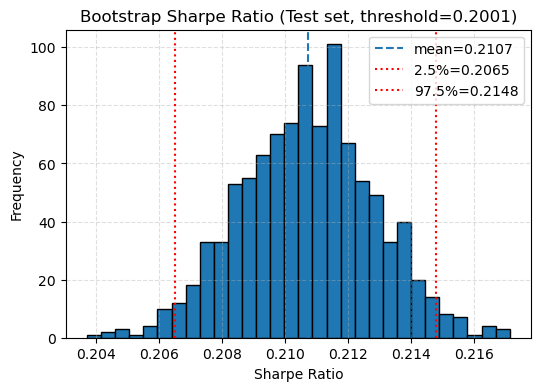

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) 단일 샤프 계산 함수
# -------------------------------
def sharpe_at_threshold(y_scaled, irr, treasury, threshold):
    """
    y_scaled: (n,) scaled & flipped 예측값 (0=high IRR 방향)
    irr, treasury: (n,) 실측 IRR, 무위험수익률
    threshold: 고정 임계치 (ex. 0.1378)
    """
    # 0=대출, 1=거절
    decision = (y_scaled > threshold).astype(int)
    # 포트폴리오 수익률 구성
    val_return = np.where(decision == 0, irr, treasury)
    excess = val_return - treasury
    std = excess.std()
    if std == 0 or np.isnan(std):
        return np.nan
    return excess.mean() / std

# -------------------------------
# 2) 부트스트랩 함수
# -------------------------------
def bootstrap_sharpe_test(
    y_scaled, irr, treasury, threshold, n_boot=1000, random_state=42, drop_nan=True
):
    """
    test set에 대해 부트스트랩으로 샤프비율 분포 추정
    - drop_nan=True: 표본 내 분산이 0 등으로 샤프 계산이 불가한 리샘플은 제거
    """
    rng = np.random.default_rng(random_state)
    n = len(y_scaled)
    sharpes = []

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)  # 복원추출
        s = sharpe_at_threshold(y_scaled[idx], irr[idx], treasury[idx], threshold)
        if drop_nan:
            if not np.isnan(s):
                sharpes.append(s)
        else:
            sharpes.append(s)

    sharpes = np.array(sharpes, dtype=float)
    return sharpes

# -------------------------------
# 3) 실행: test set 전용 입력 사용
# -------------------------------
# 준비된 벡터들:
#  - y_test_pred_scaled  : (n_test,)  [이미 좌우반전 포함]
#  - meta_test['irr']     : (n_test,)
#  - meta_test['treasury']: (n_test,)
#  - optimal_threshold_final = 0.1378  (고정)

sharpes_bs = bootstrap_sharpe_test(
    y_scaled=y_test_pred_scaled.ravel(),
    irr=meta_test['irr'].to_numpy(),
    treasury=meta_test['treasury'].to_numpy(),
    threshold=optimal_threshold_final,
    n_boot=1000,
    random_state=123
)

# 요약 통계 & 신뢰구간
sharpe_bs_mean = np.nanmean(sharpes_bs)
sharpe_bs_median = np.nanmedian(sharpes_bs)
sharpe_bs_std = np.nanstd(sharpes_bs)
ci_low, ci_high = np.nanpercentile(sharpes_bs, [2.5, 97.5])

print(f"[Test Bootstrap] Sharpe mean = {sharpe_bs_mean:.4f}, "
      f"median = {sharpe_bs_median:.4f}, "
      f"standard deviation = {sharpe_bs_std:.4f}")
print(f"[Test Bootstrap] 95% CI = ({ci_low:.4f}, {ci_high:.4f})")
print(f"[Test Bootstrap] #samples = {np.isfinite(sharpes_bs).sum()} (out of {len(sharpes_bs)})")

# -------------------------------
# 4) 시각화
# -------------------------------
plt.figure(figsize=(6,4))
plt.hist(sharpes_bs[np.isfinite(sharpes_bs)], bins=30, edgecolor='black')
plt.axvline(sharpe_bs_mean, linestyle='--', label=f"mean={sharpe_bs_mean:.4f}")
plt.axvline(ci_low, color='red', linestyle=':', label=f"2.5%={ci_low:.4f}")
plt.axvline(ci_high, color='red', linestyle=':', label=f"97.5%={ci_high:.4f}")
plt.title(f"Bootstrap Sharpe Ratio (Test set, threshold={optimal_threshold_final:.4f})")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.4, linestyle='--')
plt.show()